# Make Basic Plots
A few basic plots to show the EBTEL $T,n$ profiles, field extrapolation, contribution functions, etc.

In [138]:
import os
import io
import copy
import glob
import urllib

import numpy as np
import pandas
from scipy.optimize import curve_fit
import scipy.linalg
import scipy.stats
from scipy.interpolate import interp1d,splev,splrep
from scipy.ndimage import map_coordinates,gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import astropy.units as u
import astropy.constants as const
from sunpy.map import Map,GenericMap
from ChiantiPy.tools import filters as ch_filters

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA,InstrumentHinodeEIS
from synthesizAR.util import EISCube,EMCube
from synthesizAR.atomic import EmissionModel
from synthesizAR.model_ext import power_law_transform

sns.set_palette('deep')
sns.set_context(context='talk')

%matplotlib inline

In [2]:
frequencies = [250,750,'750-ion',2500,5000]

## Field Depiction

In [3]:
base_field = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/base_noaa1109/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-21 16:06:54,322 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-21 16:06:54,322 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-21 16:06:54,324 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-06-21 16:06:54,325 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-06-21 16:06:54,326 Parameters: cosmological_simulation   = 0.0


In [74]:
aia94 = Map('/home/wtb2/sunpy/data/aia_lev1_94a_2010_09_29t23_50_50_12z_image_lev1.fits')
aia131 = Map('/home/wtb2/sunpy/data/aia_lev1_131a_2010_09_29t23_50_57_62z_image_lev1.fits')

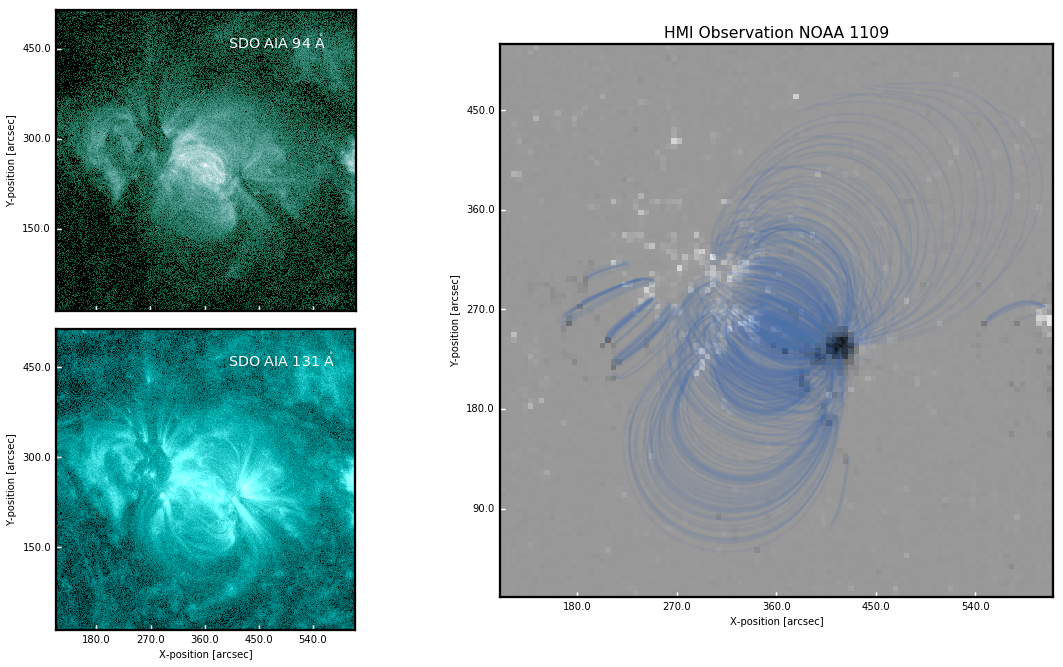

In [124]:
fig = plt.figure(figsize=(16,9))
#hmi
ax1 = plt.subplot2grid((2,2),(0,1),rowspan=2,projection=base_field.hmi_map)
base_field.hmi_map.plot(annotate=True,axes=ax1,title=False)
ax1.set_title(r'HMI Observation NOAA 1109')
ax1.coords[0].grid(alpha=0)
ax1.coords[1].grid(alpha=0)
ax1.coords[0].set_ticks(size=5)
ax1.coords[1].set_ticks(size=5)
# plot fieldlines
for stream, _ in base_field.streamlines:
        ax1.plot(base_field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
                base_field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
                alpha=0.1, color=sns.color_palette()[0], transform=ax1.get_transform('world'))
# cutout
width = base_field.hmi_map.dimensions.x*base_field.hmi_map.scale.x
height = base_field.hmi_map.dimensions.y*base_field.hmi_map.scale.y
left = base_field.hmi_map.center.x - width/2.
right = left + width
bottom = base_field.hmi_map.center.y - height/2.
top = bottom + height
#aia94
aia94_submap = aia94.submap(u.Quantity((left,right)),u.Quantity((bottom,top)))
ax2 = plt.subplot2grid((2,2),(0,0),projection=aia94_submap)
aia94_submap.plot(annotate=False,axes=ax2,title=False,norm=matplotlib.colors.SymLogNorm(1,vmin=1,vmax=1e2))
xtext,ytext = aia94_submap.data_to_pixel(400*u.arcsec,450*u.arcsec) 
ax2.text(xtext.value,ytext.value,r'SDO AIA 94 $\mathrm{\mathring{A}}$',
         color='w',fontsize=matplotlib.rcParams['axes.labelsize'])
ax2.coords[0].set_ticklabel_visible(False)
ax2.coords[0].grid(alpha=0)
ax2.coords[1].grid(alpha=0)
ax2.coords[0].set_ticks(size=5)
ax2.coords[1].set_ticks(size=5)
ax2.set_ylabel(r'Y-position [arcsec]')
#aia131
aia131_submap = aia131.submap(u.Quantity((left,right)),u.Quantity((bottom,top)))
ax3 = plt.subplot2grid((2,2),(1,0),projection=aia131_submap)
aia131_submap.plot(annotate=True,axes=ax3,title=False,norm=matplotlib.colors.SymLogNorm(1,vmin=1,vmax=1e3))
ax3.coords[0].grid(alpha=0)
ax3.coords[1].grid(alpha=0)
ax3.coords[0].set_ticks(size=5)
ax3.coords[1].set_ticks(size=5)
ax3.text(xtext.value,ytext.value,r'SDO AIA 131 $\mathrm{\mathring{A}}$',
         color='w',fontsize=matplotlib.rcParams['axes.labelsize'])

plt.tight_layout()
fig.savefig('../loops-workshop-2017-talk/template/img/aia_and_hmi_observations.png',bbox_inches='tight',dpi=200)

## Plot Heating and Temperature Profiles

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-25 04:02:36,312 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-25 04:02:36,313 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-25 04:02:36,315 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-06-25 04:02:36,316 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-06-25 04:02:36,317 Parameters: cosmological_simulation   = 0.0
No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-25 04:03:00,841 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-25 04:03:00,842 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-25 04:03:00,844 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017

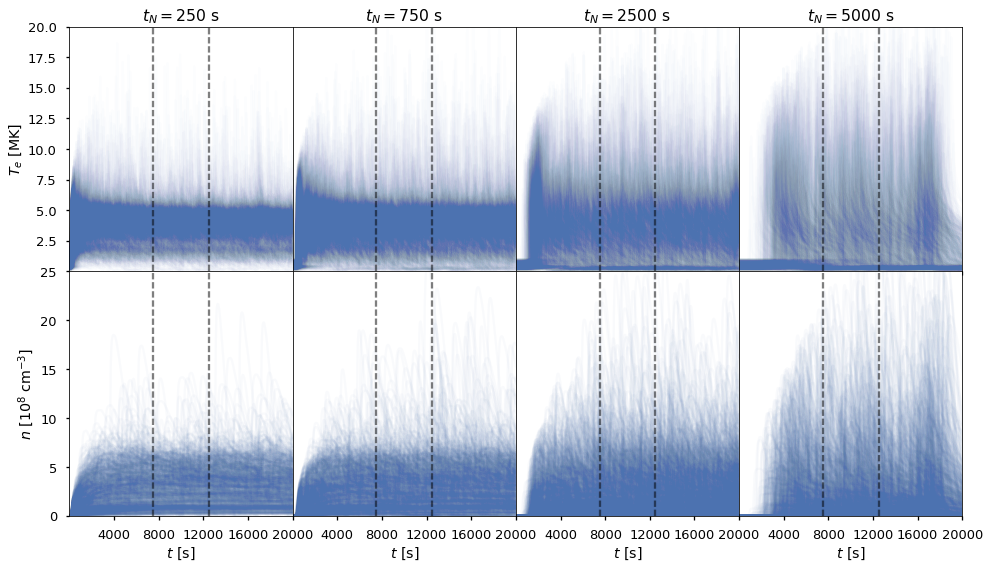

In [151]:
fig,axes = plt.subplots(2,4,figsize=(16,9),sharex=True)
plt.subplots_adjust(wspace=0.,hspace=0.)
for i,freq in enumerate([250,750,2500,5000]):
    field = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_tn{}/field_checkpoint/'.format(freq))
    for loop in field.loops:#[field.loops[0],field.loops[1]]:
        axes[0,i].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),alpha=0.01,color=sns.color_palette()[0])
        axes[1,i].plot(loop.time,loop.density[:,0]/1e9,alpha=0.03,color=sns.color_palette()[0])
    axes[0,i].set_xlim([0,2e4])
    axes[0,i].set_ylim([0,20])
    axes[1,i].set_ylim([0,25])
    axes[0,i].yaxis.set_major_locator(MaxNLocator(nbins=len(axes[0,i].get_yticklabels()), prune='lower'))
    if i>0:
        axes[0,i].set_yticks([])
        axes[1,i].set_yticks([])
        axes[0,i].set_yticklabels([],visible=False)
        axes[1,i].set_yticklabels([],visible=False)
        axes[1,i].xaxis.set_major_locator(MaxNLocator(nbins=len(axes[1,i].get_xticklabels()), prune='lower'))
    else:
        axes[0,i].set_ylabel(r'$T_e$ [MK]')
        axes[1,i].set_ylabel(r'$n$ [10$^8$ cm$^{-3}$]')
    axes[0,i].set_title(r'$t_N={}$ s'.format(freq))
    axes[1,i].set_xlabel(r'$t$ [s]')
    axes[0,i].axvline(x=7500,color='k',ls='--',alpha=0.5)
    axes[0,i].axvline(x=12500,color='k',ls='--',alpha=0.5)
    axes[1,i].axvline(x=7500,color='k',ls='--',alpha=0.5)
    axes[1,i].axvline(x=12500,color='k',ls='--',alpha=0.5)
fig.savefig('../loops-workshop-2017-talk/template/img/temperature_density_profiles.png',dpi=200,bbox_inches='tight')
        

## Plot Heating Frequency

In [9]:
event_energies = {'{}'.format(freq):[] for freq in frequencies}
event_wait_times = {'{}'.format(freq):[] for freq in frequencies}
total_energy = {'{}'.format(freq):[] for freq in frequencies}

In [10]:
for freq in frequencies:
    if type(freq) == int:
        field = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_tn{}/field_checkpoint/'.format(freq))
    else:
        field = synthesizAR.Skeleton.restore('/data/datadrive2/ar_viz/systematic_ar_study/noaa1109_tn750-ion/field_checkpoint/')
    for loop in field.loops:
        num_events = len(loop.hydro_configuration['heating']['events'])
        tmp_event_energies = []
        for i,event in enumerate(loop.hydro_configuration['heating']['events']):
            if i > 0:
                event_wait_times['{}'.format(freq)].append(event['event']['rise_start'] 
                                        - loop.hydro_configuration['heating']['events'][i-1]['event']['rise_end'])
            tmp_event_energies.append(event['event']['magnitude'])
            event_energies['{}'.format(freq)].append(event['event']['magnitude'])
        total_energy['{}'.format(freq)].append(np.array(tmp_event_energies).sum()*100.)

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-21 18:22:35,756 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-21 18:22:35,757 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-21 18:22:35,758 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-06-21 18:22:35,759 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-06-21 18:22:35,760 Parameters: cosmological_simulation   = 0.0
No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-21 18:22:44,527 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-21 18:22:44,528 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-21 18:22:44,529 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017

(1, 10000.0)

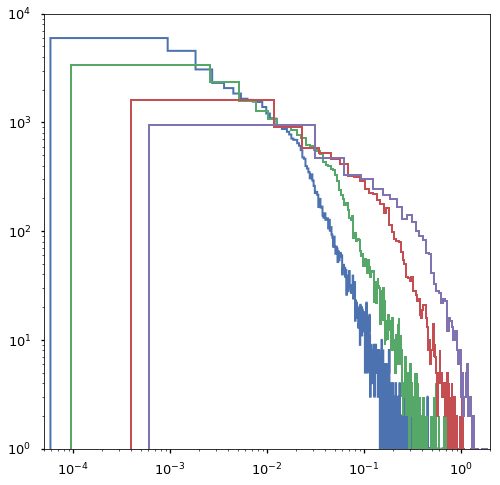

In [70]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
for freq in [250,750,2500,5000]:
    _,bins = np.histogram(event_energies['{}'.format(freq)],bins='fd')
    #bins = np.linspace(1e-4,1,100)
    ax.hist(event_energies['{}'.format(freq)],log=True,bins=bins,histtype='step',lw=2)
ax.set_xscale('log')
ax.set_xlim([5e-5,2])
ax.set_ylim([1,1e4])

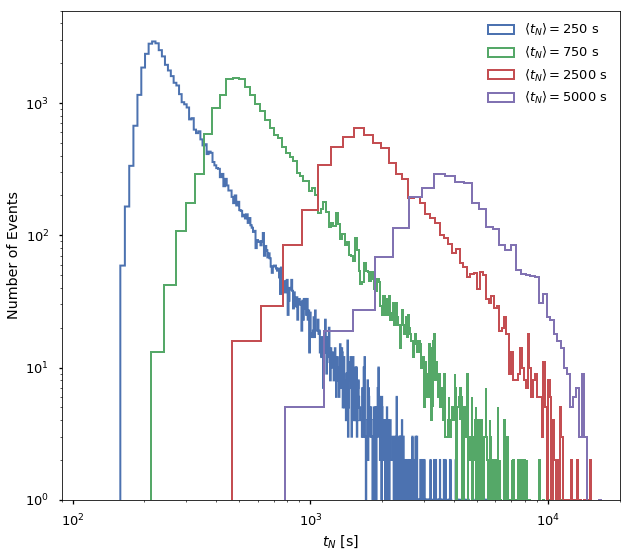

In [121]:
fig = plt.figure(figsize=(10,9))
ax = fig.gca()
for freq in [250,750,2500,5000]:
    _,bins = np.histogram(event_wait_times['{}'.format(freq)],bins='fd')
    ax.hist(event_wait_times['{}'.format(freq)],log=True,bins=bins,histtype='step',lw=2,
            label=r'$\langle t_N\rangle={}$ s'.format(freq))
ax.set_xscale('log')
ax.set_ylim([1,5e3])
ax.set_xlim([9e1,2e4])
ax.set_xlabel(r'$t_N$ [s]')
ax.set_ylabel(r'Number of Events')
leg = ax.legend(loc=1,frameon=False)
fig.savefig('../loops-workshop-2017-talk/template/img/wait_time_distribution.png',bbox_inches='tight',dpi=200)

In [63]:
total_samples = {s:[] for s in [50,20,10,5]}
intervals = {s:[] for s in [50,20,10,5]}
for s in [50,20,10,5]:
    total_samples_tmp = []
    for _ in range(100000):
        a0 = (5e-5 + np.random.power(0.5)*(5.5e-5 - 5e-5))
        a1 = 100*a0
        total_samples_tmp.append(power_law_transform(np.random.rand(s),a0,a1,-2.5))
        intervals[s].append((a0,a1))
    total_samples[s] = np.array(total_samples_tmp).flatten()

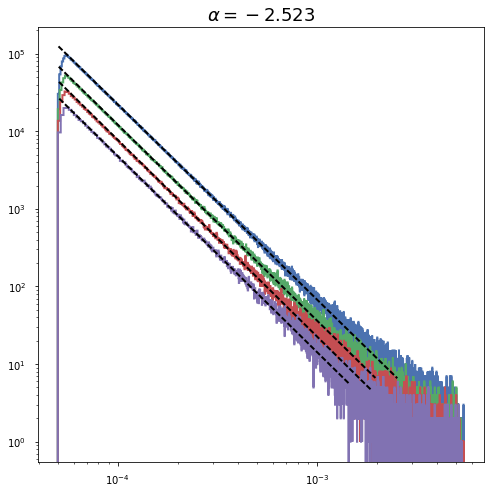

In [67]:
plt.figure(figsize=(8,8))
for s in [50,20,10,5]:
    _,bins = np.histogram(total_samples[s],bins='fd')
    #bins = 20
    hist,bins,_ = plt.hist(total_samples[s],bins=bins,histtype='step',lw=2,label=r'$s = {}$'.format(s))
    bin_centers = (bins[1:] + bins[:-1])/2.
    inz = np.where(hist==0)
    if len(inz[0]) > 0:
        hist = hist[:inz[0][0]]
        bin_centers = bin_centers[:inz[0][0]]
    foo_x = np.linspace(bin_centers[0],bin_centers[-1],1000)
    coefs = np.polyfit(np.log10(bin_centers),np.log10(hist),1)
    plt.plot(foo_x,10.**(coefs[1])*foo_x**(coefs[0]),lw=2,ls='--',color='k')
#for i in intervals:
#    plt.plot([i[0],i[1]],[10,10],ls='-',marker='|',alpha=0.1,color='k',markersize=20)
plt.xscale('log')
plt.yscale('log')
plt.title(r'$\alpha={:.3f}$'.format(coefs[0]))